In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from scipy import misc
import xgboost as xgb
import os
import re
import time
#import h5py
import pickle
from tqdm import tqdm
import cv2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
color = sns.color_palette()

%matplotlib inline

In [2]:
DATA_PATH = '/kaggle/dev/carvana-image-masking-challenge-data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw_data')
TRAIN_PATH = os.path.join(RAW_DATA_PATH, 'train')
TEST_PATH = os.path.join(RAW_DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(RAW_DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(RAW_DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(RAW_DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
ASSETS_PATH = os.path.join(DATA_PATH, 'assets')
MODELS_PATH = os.path.join(ASSETS_PATH, 'models')
TENSORBOARD_PATH = os.path.join(ASSETS_PATH, 'tensorboard')

# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

HEIGHT = 1024
WIDTH = 1024
CHANNELS = 3
new_shape = (HEIGHT, WIDTH, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

In [3]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)

metadata_df = pd.read_csv(METADATA_PATH)
print('metadata_df.shape', metadata_df.shape)

train_masks_df.shape (5088, 2)
metadata_df.shape (6572, 6)


In [204]:
# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id):
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    imgplot = plt.imshow(mask)
    plt.axis('off')
    plt.show()
    
def plot_masked_image(img_id):
    img = mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    imgplot = plt.imshow(masked_img)
    plt.axis('off')
    plt.show()

def get_img(img_id):
    return mpimg.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
       
def get_mask(img_id, num_channels=-1):
    if num_channels!=-1:
        mask = misc.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"), flatten=True)
        mask[mask > 128] = 1
        if len(mask.shape) == 2:
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        return mask
    else:
        mask = mpimg.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
        mask = mask[:,:,0:3]
        return mask

In [205]:
# faulty_ids = ['8d1a6723c458_01', 
#               '8d1a6723c458_08'
#              ]

# for ids in faulty_ids:
#     print('Car id {}'.format(ids))
#     plot_mask(ids)
#     plot_masked_image(ids)

In [250]:
def check_mask(mask_id):
    print("mask id:", mask_id)
    plot_mask(mask_id)
    img = get_img(mask_id)
    mask = get_mask(mask_id, 1)
    masked_img = img * mask
#     print('mask:', mask.shape) 
#     print('img:', img.shape)
#     imgplot = plt.imshow(masked_img)
#     plt.axis('off')
#     plt.show()
    mask = get_mask(mask_id, -1)
    threshold = 127
    imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255,0)
    im2, contours, hierachy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    im = cv2.drawContours(imgray, contours, -1, (255,255,255), 3)
    imgplot = plt.imshow(im)
    plt.axis('off')
    plt.show()
    

mask id: 8d1a6723c458_01


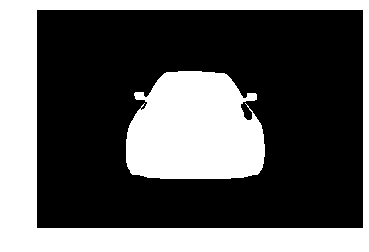

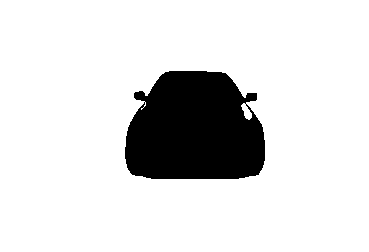

In [252]:
#check_mask(train_masks_df.iloc[0,0][0:-4])
check_mask('8d1a6723c458_01')